# Multi-Digit Recognition

In [1]:
import h5py, cv2, torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'Greys'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Dataset

In [2]:
hf = h5py.File('MNIST_synthetic.h5', 'r')
list(hf.values())

[<HDF5 dataset "test_dataset": shape (14000, 64, 64, 1), type "|u1">,
 <HDF5 dataset "train_dataset": shape (56000, 64, 64, 1), type "|u1">,
 <HDF5 dataset "train_labels": shape (56000, 5), type "<i4">]

In [3]:
# Getting dataset values
test_dataset_raw = hf.get('test_dataset')[()]
train_dataset_raw = hf.get('train_dataset')[()]
train_labels_raw = hf.get('train_labels')[()]

In [4]:
# X : NCHW (dataset size, chanels, height, weight)
train_dataset = train_dataset_raw.transpose(0,3,1,2)
train_dataset.shape

(56000, 1, 64, 64)

In [5]:
# y : N*c (dataset size, number of classes) <- rename this c?
train_labels = train_labels_raw
train_labels.shape

(56000, 5)

[[ 8  5  0  3 10]
 [ 8  9  9  8  7]
 [ 1  7  9  1  8]
 [ 5  2  6 10 10]
 [ 2 10 10 10 10]]


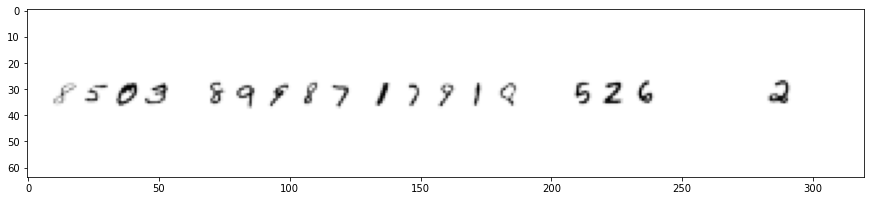

In [6]:
# Visualize first five train images
img = np.concatenate(tuple(train_dataset[:5]),axis=2)[0,:,:]
plt.figure(figsize=(15,75))
plt.imshow(img)
print(train_labels[:5])

## Preprocessing

In [7]:
# Crops a single synthetic image into a list of 5 digit images
def cropimg(img0):
    img = 255 - img0
  
    img0 = cv2.resize(img0, (512,512), interpolation = cv2.INTER_AREA) 
    temp = cv2.resize(img, (512,512), interpolation = cv2.INTER_AREA) 
    img=temp

    dim = (512, 512)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 
    img = resized
    ret, im_th = cv2.threshold(img, 245, 255, cv2.THRESH_BINARY_INV)
    ctrs, hier = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    borders={}
    names=[]

    for ctr in ctrs:
        x, y, w, h = cv2.boundingRect(ctr)
        borders[x] = (x,y,w,h)
        names.append(x)
    borders=dict(sorted(borders.items()))
    names.sort()
    results = np.zeros((5,1,32,32), dtype='uint8')
    i=0
    size=(32,32)
    
    for m in range(len(names)-1):
        if borders[names[m+1]][0]-borders[names[m]][0]<15 and (borders[names[m+1]][3]>=60 or borders[names[m+1]][2]>=50):
            (x,y,w,h)=borders[names[m]]
            (x1,y1,w1,h1)=borders[names[m+1]]
            borders[names[m]]=(x,min(y,y1),max(w,w1),max(y,y1)-min(y,y1)+max(h,h1))
            borders[names[m+1]]=(0,0,0,0)
  
    for key,rect in borders.items():
        if rect[3] < 60 and rect[2]<50:
            continue
        borderImg=img0[rect[1]-10:rect[1]+rect[3]+10,rect[0]-10:rect[0]+rect[2]+10]
        extendPiexl = (max(borderImg.shape) - min(borderImg.shape)) // 2
        targetImg = cv2.copyMakeBorder(borderImg, 7, 7, extendPiexl + 7, extendPiexl + 7, cv2.BORDER_CONSTANT)
        targetImg = cv2.resize(targetImg, size)   
        targetImg = np.expand_dims(targetImg, axis=0)
        results[i]=targetImg
        i+=1
    
    if len(borders)<5:
        temp=np.zeros((1,32,32), dtype='uint8')
        temp.fill(0)
        for num in range(5-len(borders)):
            results[len(borders)+num]=temp
  
    return results

In [8]:
# Crops the whole dataset, returns a Tensor
def cropDataset(dataset1):
    dim=dataset1.shape
    out=np.zeros((dim[0]*5,1,32,32), dtype='uint8')
  
    for m in range(dim[0]):
        images=cropimg(dataset1[m][0])
        out[0+m*5:5+m*5]=images
    
    return torch.from_numpy(out)

In [9]:
train_dataset_cropped = cropDataset(train_dataset)
train_dataset_cropped = train_dataset_cropped.reshape((-1,5,1,32,32))
train_dataset_cropped.shape

torch.Size([56000, 5, 1, 32, 32])

[[ 8  5  0  3 10]]


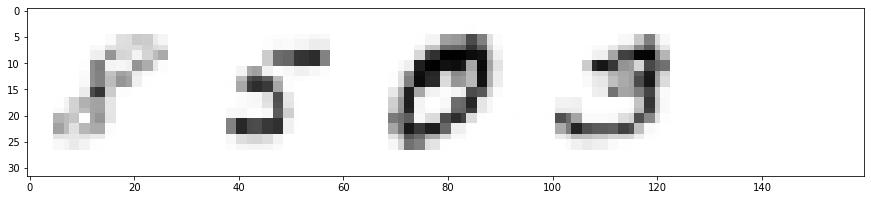

In [11]:
# Visualize first cropped image group
for i in range(1):
    img = np.concatenate(tuple(train_dataset_cropped[i,:]),axis=2)[0,:,:]
    plt.figure(figsize=(15,75))
    plt.imshow(img)
print(train_labels[:1])

# Parameter Tuning

## Depth of each layer

### Shallow

In [55]:
# Shallow net
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self._conv0 = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.25)
        )

        self._conv1 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25) 
        )
        
        self._conv2 =nn.Sequential(
            nn.Conv2d(64, 128, 4),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25) 
        )

        self._lr0 = nn.Sequential(
            nn.Linear(128*25*25,11)
        )

    def forward(self, x):
        x = self._conv0(x)
        x = self._conv1(x)
        x = self._conv2(x)
        x = x.view(-1,128*25*25)
        x = self._lr0(x)
        x = F.log_softmax(x,dim=1)

        return x


In [56]:
# Trainloader
train_x = train_dataset_cropped[:-100].float()
train_y = torch.Tensor(train_labels[:-100]).long()
trainset = torch.utils.data.TensorDataset(train_x, train_y)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
# Validation set
val_x = train_dataset_cropped[-100:].float()
val_y = torch.Tensor(train_labels[-100:]).long()
# Model, loss function, optimizer
net = Net()
net = net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

In [57]:
epoch_loss_shallow = np.array([])
epoch_loss_val_shallow = np.array([])

In [58]:
# Train the network
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.reshape((-1,1,32,32))
        labels = labels.reshape((-1))
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 125 == 124:    # print every 125 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 125))
            epoch_loss_shallow = np.append(epoch_loss_shallow, (running_loss / 125))
            running_loss = 0.0
    # calculate validation loss
    with torch.no_grad():
        inputs = val_x.reshape((-1,1,32,32))
        labels = val_y.reshape((-1))
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        epoch_loss_val_shallow = np.append(epoch_loss_val_shallow, loss.item())

print('Finished Training')

[1,   125] loss: 0.240
[1,   250] loss: 0.110
[1,   375] loss: 0.105
[1,   500] loss: 0.089
[1,   625] loss: 0.091
[1,   750] loss: 0.084
[2,   125] loss: 0.071
[2,   250] loss: 0.070
[2,   375] loss: 0.069
[2,   500] loss: 0.064
[2,   625] loss: 0.073
[2,   750] loss: 0.068
[3,   125] loss: 0.065
[3,   250] loss: 0.060
[3,   375] loss: 0.065
[3,   500] loss: 0.052
[3,   625] loss: 0.061
[3,   750] loss: 0.063
[4,   125] loss: 0.058
[4,   250] loss: 0.050
[4,   375] loss: 0.058
[4,   500] loss: 0.043
[4,   625] loss: 0.062
[4,   750] loss: 0.056
[5,   125] loss: 0.051
[5,   250] loss: 0.052
[5,   375] loss: 0.059
[5,   500] loss: 0.044
[5,   625] loss: 0.062
[5,   750] loss: 0.055
Finished Training


In [60]:
loss_shallow = epoch_loss_shallow.reshape((-1,6))[:,-1]
loss_shallow

array([0.08388681, 0.06771943, 0.06276264, 0.05582295, 0.05456411])

### Mid

In [73]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self._conv0 = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 5, stride=2, padding=2), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.25)
        )

        self._conv1 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64), 
            nn.Conv2d(64, 64, 5, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25) 
        )
        
        self._conv2 =nn.Sequential(
            nn.Conv2d(64, 128, 4),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25) 
        )

        self._lr0 = nn.Sequential(
            nn.Linear(128*3*3,11)
        )

    def forward(self, x):
        x = self._conv0(x)
        x = self._conv1(x)
        x = self._conv2(x)
        
        x = x.view(-1,128*3*3)
        x = self._lr0(x)
        x = F.log_softmax(x,dim=1)

        return x


In [74]:
# Trainloader
train_x = train_dataset_cropped[:-100].float()
train_y = torch.Tensor(train_labels[:-100]).long()
trainset = torch.utils.data.TensorDataset(train_x, train_y)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
# Validation set
val_x = train_dataset_cropped[-100:].float()
val_y = torch.Tensor(train_labels[-100:]).long()
# Model, loss function, optimizer
net = Net()
net = net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

In [75]:
epoch_loss_mid = np.array([])
epoch_loss_val_mid = np.array([])

In [76]:
# Train the network
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.reshape((-1,1,32,32))
        labels = labels.reshape((-1))
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 125 == 124:    # print every 125s mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 125))
            epoch_loss_mid = np.append(epoch_loss_mid, (running_loss / 125))
            running_loss = 0.0
    # calculate validation loss
    with torch.no_grad():
        inputs = val_x.reshape((-1,1,32,32))
        labels = val_y.reshape((-1))
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        epoch_loss_val_mid = np.append(epoch_loss_val_mid, loss.item())

print('Finished Training')

[1,   125] loss: 0.699
[1,   250] loss: 0.218
[1,   375] loss: 0.145
[1,   500] loss: 0.122
[1,   625] loss: 0.105
[1,   750] loss: 0.088
[2,   125] loss: 0.076
[2,   250] loss: 0.072
[2,   375] loss: 0.071
[2,   500] loss: 0.064
[2,   625] loss: 0.061
[2,   750] loss: 0.058
[3,   125] loss: 0.065
[3,   250] loss: 0.051
[3,   375] loss: 0.053
[3,   500] loss: 0.049
[3,   625] loss: 0.049
[3,   750] loss: 0.048
[4,   125] loss: 0.047
[4,   250] loss: 0.044
[4,   375] loss: 0.050
[4,   500] loss: 0.044
[4,   625] loss: 0.043
[4,   750] loss: 0.040
[5,   125] loss: 0.037
[5,   250] loss: 0.046
[5,   375] loss: 0.042
[5,   500] loss: 0.039
[5,   625] loss: 0.040
[5,   750] loss: 0.038
Finished Training


In [77]:
loss_mid = epoch_loss_mid.reshape((-1,6))[:,-1]
loss_mid

array([0.08839003, 0.05791786, 0.04783739, 0.03964011, 0.03821096])

### Deep

In [12]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self._conv0 = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32), 
            nn.Conv2d(32, 32, 5, stride=2, padding=2), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.25)
        )

        self._conv1 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64), 
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64), 
            nn.Conv2d(64, 64, 5, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25) 
        )
        
        self._conv2 =nn.Sequential(
            nn.Conv2d(64, 128, 4),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25) 
        )

        self._lr0 = nn.Sequential(
            nn.Linear(128,11)
        )

    def forward(self, x):
        x = self._conv0(x)
        x = self._conv1(x)
        x = self._conv2(x)

        x = x.view(-1,128)
        x = self._lr0(x)
        x = F.log_softmax(x,dim=1)

        return x


In [79]:
# Trainloader
train_x = train_dataset_cropped[:-100].float()
train_y = torch.Tensor(train_labels[:-100]).long()
trainset = torch.utils.data.TensorDataset(train_x, train_y)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
# Validation set
val_x = train_dataset_cropped[-100:].float()
val_y = torch.Tensor(train_labels[-100:]).long()
# Model, loss function, optimizer
net = Net()
net = net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

In [80]:
epoch_loss_deep = np.array([])
epoch_loss_val_deep = np.array([])

In [81]:
# Train the network
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.reshape((-1,1,32,32))
        labels = labels.reshape((-1))
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 125 == 124:    # print every 125 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 125))
            epoch_loss_deep = np.append(epoch_loss_deep, (running_loss / 125))
            running_loss = 0.0
    # calculate validation loss
    with torch.no_grad():
        inputs = val_x.reshape((-1,1,32,32))
        labels = val_y.reshape((-1))
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        epoch_loss_val_deep = np.append(epoch_loss_val_deep, loss.item())

print('Finished Training')

[1,   125] loss: 0.811
[1,   250] loss: 0.274
[1,   375] loss: 0.174
[1,   500] loss: 0.137
[1,   625] loss: 0.107
[1,   750] loss: 0.092
[2,   125] loss: 0.076
[2,   250] loss: 0.068
[2,   375] loss: 0.067
[2,   500] loss: 0.067
[2,   625] loss: 0.061
[2,   750] loss: 0.056
[3,   125] loss: 0.054
[3,   250] loss: 0.052
[3,   375] loss: 0.056
[3,   500] loss: 0.047
[3,   625] loss: 0.049
[3,   750] loss: 0.047
[4,   125] loss: 0.035
[4,   250] loss: 0.041
[4,   375] loss: 0.046
[4,   500] loss: 0.041
[4,   625] loss: 0.049
[4,   750] loss: 0.046
[5,   125] loss: 0.040
[5,   250] loss: 0.041
[5,   375] loss: 0.036
[5,   500] loss: 0.039
[5,   625] loss: 0.039
[5,   750] loss: 0.040
Finished Training


In [82]:
loss_deep = epoch_loss_deep.reshape((-1,6))[:,-1]
loss_deep.shape

(5,)

### Plot different layer depths

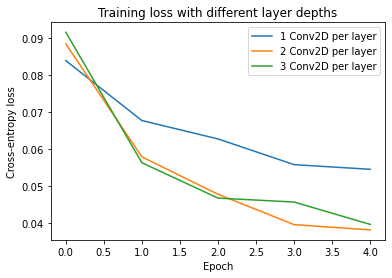

In [83]:
plt.plot(range(len(loss_shallow)), loss_shallow, label='1 Conv2D per layer')
plt.plot(range(len(loss_mid)), loss_mid, label='2 Conv2D per layer')
plt.plot(range(len(loss_deep)), loss_deep, label='3 Conv2D per layer')
plt.title("Training loss with different layer depths")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.legend(loc='upper right')
plt.show()

## Batch size

In [15]:
# Trainloader
trainloader = [0] * 3
train_x = train_dataset_cropped[:-100].float()
train_y = torch.Tensor(train_labels[:-100]).long()
trainset = torch.utils.data.TensorDataset(train_x, train_y)
for i in range(3) :
    trainloader[i] = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
# Validation set
val_x = train_dataset_cropped[-100:].float()
val_y = torch.Tensor(train_labels[-100:]).long()
# Model, loss function, optimizer
net = [0] * 3
criterion = [0] * 3 
optimizer = [0] * 3 
for i in range(3) :
    net[i] = Net()
    net[i] = net[i].cuda()
    criterion[i] = nn.CrossEntropyLoss()
    optimizer[i] = torch.optim.Adam(net[i].parameters(), lr=1e-4)

In [16]:
epoch_loss = [0] * 3
epoch_loss_val = [0] * 3
for i in range(3) :
    epoch_loss[i] = np.array([])
    epoch_loss_val[i] = np.array([])

In [17]:
# Train the network
batch_size = [4,16,64]
for i in range(3) :
    print('Batch Size {0:d}'.format(batch_size[i]))
    for epoch in range(5):  # loop over the dataset multiple times
        running_loss = 0.0
        for j, data in enumerate(trainloader[i], 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.reshape((-1,1,32,32))
            labels = labels.reshape((-1))
            inputs = inputs.cuda()
            labels = labels.cuda()

            # zero the parameter gradients
            optimizer[i].zero_grad()

            # forward + backward + optimize
            outputs = net[i](inputs)
            loss = criterion[i](outputs, labels)
            loss.backward()
            optimizer[i].step()

            # print statistics
            running_loss += loss.item()
            if j % 125 == 124:    # print every 125 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, j + 1, running_loss / 125))
                epoch_loss[i] = np.append(epoch_loss[i], (running_loss / 125))
                running_loss = 0.0
        # calculate validation loss
        with torch.no_grad():
            inputs = val_x.reshape((-1,1,32,32))
            labels = val_y.reshape((-1))
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = net[i](inputs)
            loss = criterion[i](outputs, labels)
            epoch_loss_val[i] = np.append(epoch_loss_val[i], loss.item())

    print('Finished Training')

Batch Size 4
[1,   125] loss: 0.839
[1,   250] loss: 0.303
[1,   375] loss: 0.188
[1,   500] loss: 0.138
[1,   625] loss: 0.111
[1,   750] loss: 0.095
[2,   125] loss: 0.074
[2,   250] loss: 0.072
[2,   375] loss: 0.063
[2,   500] loss: 0.068
[2,   625] loss: 0.058
[2,   750] loss: 0.064
[3,   125] loss: 0.051
[3,   250] loss: 0.052
[3,   375] loss: 0.050
[3,   500] loss: 0.049
[3,   625] loss: 0.047
[3,   750] loss: 0.048
[4,   125] loss: 0.044
[4,   250] loss: 0.044
[4,   375] loss: 0.043
[4,   500] loss: 0.040
[4,   625] loss: 0.042
[4,   750] loss: 0.041
[5,   125] loss: 0.036
[5,   250] loss: 0.037
[5,   375] loss: 0.037
[5,   500] loss: 0.037
[5,   625] loss: 0.034
[5,   750] loss: 0.041
Finished Training
Batch Size 16
[1,   125] loss: 0.802
[1,   250] loss: 0.282
[1,   375] loss: 0.176
[1,   500] loss: 0.133
[1,   625] loss: 0.110
[1,   750] loss: 0.093
[2,   125] loss: 0.077
[2,   250] loss: 0.070
[2,   375] loss: 0.064
[2,   500] loss: 0.062
[2,   625] loss: 0.059
[2,   750] l

In [18]:
loss = [0] * 3
for i in range(3) :
    loss[i] = epoch_loss[i].reshape((-1,6))[:,-1]
loss

[array([0.09462449, 0.06412257, 0.04817074, 0.04062952, 0.04135608]),
 array([0.09321165, 0.06048244, 0.04601078, 0.04316928, 0.03829029]),
 array([0.09606637, 0.05420374, 0.04893441, 0.04460038, 0.03570664])]

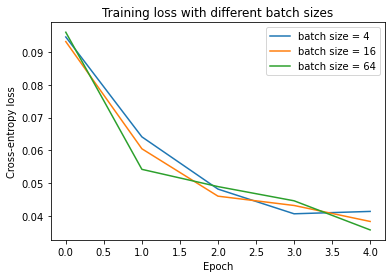

In [19]:
plt.plot(range(5), loss[0], label='batch size = 4')
plt.plot(range(5), loss[1], label='batch size = 16')
plt.plot(range(5), loss[2], label='batch size = 64')
plt.title("Training loss with different batch sizes")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.legend(loc='upper right')
plt.show()

# Training and prediction

## Model

In [12]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self._conv0 = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32), 
            nn.Conv2d(32, 32, 5, stride=2, padding=2), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.25)
        )

        self._conv1 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64), 
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64), 
            nn.Conv2d(64, 64, 5, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25) 
        )
        
        self._conv2 =nn.Sequential(
            nn.Conv2d(64, 128, 4),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25) 
        )

        self._lr0 = nn.Sequential(
            nn.Linear(128,11)
        )

    def forward(self, x):
        x = self._conv0(x)
        x = self._conv1(x)
        x = self._conv2(x)

        x = x.view(-1,128)
        x = self._lr0(x)
        x = F.log_softmax(x,dim=1)

        return x


## Training

In [106]:
# Trainloader
train_x = train_dataset_cropped[:-100].float()
train_y = torch.Tensor(train_labels[:-100]).long()
trainset = torch.utils.data.TensorDataset(train_x, train_y)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

In [107]:
# Validation set
val_x = train_dataset_cropped[-100:].float()
val_y = torch.Tensor(train_labels[-100:]).long()

In [108]:
# Testloader
test_dataset = test_dataset_raw.transpose(0,3,1,2)
test_dataset_cropped = cropDataset(test_dataset)
test_dataset_cropped = test_dataset_cropped.reshape((-1,5,1,32,32))

test_x = test_dataset_cropped.float()
test_y = torch.ones(test_dataset_cropped.shape[0],5) # pseudo labels for pytorch TensorDataset
testset = torch.utils.data.TensorDataset(test_x, test_y)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=2)

In [109]:
# Model, loss function, optimizer
net = Net()
net = net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

In [110]:
epoch_loss = np.array([])
epoch_loss_val = np.array([])

In [111]:
# Train the network
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.reshape((-1,1,32,32))
        labels = labels.reshape((-1))
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 125 == 124:    # print every 125 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 125))
            epoch_loss = np.append(epoch_loss, (running_loss / 125))
            running_loss = 0.0
    # calculate validation loss
    with torch.no_grad():
        inputs = val_x.reshape((-1,1,32,32))
        labels = val_y.reshape((-1))
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        epoch_loss_val = np.append(epoch_loss_val, loss.item())

print('Finished Training')

[1,   125] loss: 0.805
[1,   250] loss: 0.276
[1,   375] loss: 0.176
[1,   500] loss: 0.130
[1,   625] loss: 0.107
[1,   750] loss: 0.096
[2,   125] loss: 0.071
[2,   250] loss: 0.066
[2,   375] loss: 0.066
[2,   500] loss: 0.068
[2,   625] loss: 0.064
[2,   750] loss: 0.059
[3,   125] loss: 0.053
[3,   250] loss: 0.047
[3,   375] loss: 0.056
[3,   500] loss: 0.046
[3,   625] loss: 0.054
[3,   750] loss: 0.049
[4,   125] loss: 0.047
[4,   250] loss: 0.045
[4,   375] loss: 0.038
[4,   500] loss: 0.042
[4,   625] loss: 0.036
[4,   750] loss: 0.045
[5,   125] loss: 0.043
[5,   250] loss: 0.030
[5,   375] loss: 0.035
[5,   500] loss: 0.043
[5,   625] loss: 0.044
[5,   750] loss: 0.042
[6,   125] loss: 0.038
[6,   250] loss: 0.033
[6,   375] loss: 0.036
[6,   500] loss: 0.039
[6,   625] loss: 0.034
[6,   750] loss: 0.033
[7,   125] loss: 0.032
[7,   250] loss: 0.033
[7,   375] loss: 0.029
[7,   500] loss: 0.033
[7,   625] loss: 0.040
[7,   750] loss: 0.033
[8,   125] loss: 0.029
[8,   250] 

In [112]:
loss = epoch_loss.reshape((-1,6))[:,-1]
loss

array([0.09643633, 0.05882401, 0.04928407, 0.04538844, 0.04225561,
       0.03310669, 0.03298904, 0.02891193, 0.02603716, 0.03251626,
       0.03246312, 0.02778192, 0.02721626, 0.02666887, 0.02376602,
       0.02799142, 0.01785416, 0.02274881, 0.02300568, 0.0234077 ])

In [113]:
epoch_loss_val

array([0.05601961, 0.025375  , 0.01736503, 0.00973326, 0.01197721,
       0.00897908, 0.01503765, 0.01599278, 0.00647996, 0.00984   ,
       0.00682373, 0.00646178, 0.01075508, 0.01410765, 0.01283732,
       0.00758939, 0.00959684, 0.0111522 , 0.00316822, 0.00483543])

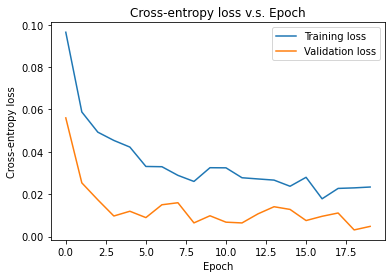

In [115]:
plt.plot(range(20), loss, label='Training loss')
plt.plot(range(20), epoch_loss_val, label='Validation loss')
plt.title("Cross-entropy loss v.s. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.legend(loc='upper right')
plt.show()

## Prediction

In [116]:
# Predict the test dataset
test_predictions = np.array([])

with torch.no_grad():
    for data in testloader:
        images,_ = data
        images = images.reshape((-1,1,32,32))
        images = images.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        test_predictions = np.append(test_predictions, predicted.cpu().numpy().reshape((-1,5)))
        
test_predictions = test_predictions.reshape((-1,5))

In [117]:
# Save the prediction for test dataset
test_predictions_str = np.apply_along_axis(lambda x : ''.join(map(str, x)), axis=1, arr=test_predictions.astype(int))
test_predictions_pd = pd.DataFrame(test_predictions_str,columns=['Label'])
test_predictions_pd['Id'] = test_predictions_pd.index
test_predictions_pd.sort_index(axis=1,inplace=True)
test_predictions_pd.to_csv('outputs.csv', index=False)
test_predictions_pd

,Id,Label
0,0,910101010
1,1,017310
2,2,14083
3,3,010101010
4,4,467810
...,...,...
13995,13995,110101010
13996,13996,604110
13997,13997,310101010
13998,13998,419710
